# Collating Results

<br><br>
___
### Cleaning Data

In [116]:
# !git clone https://github.com/Sakib56/MInf-2.0-DeepFake-Detection.git
# %cd "/content/MInf-2.0-DeepFake-Detection"

In [117]:
from scipy.stats import ttest_ind, ttest_rel
import matplotlib.pyplot as plt
from scipy.stats import t
import seaborn as sns
import pandas as pd
import numpy as np
import ast
import os
import re

sns.set()
plt.rc("font", family="serif")

# os.listdir(".")

In [118]:
def get_metric_from_file(fpath, metric="auc"):
    with open(fpath, "r") as f:
        experiment_name, _, _, _ = ast.literal_eval(f.readline().strip())  # (experiment_name, model_name, test_dataset, fpath)
        auc = f.readline()
        f1 = f.readline()
        prec = f.readline()
        recall = f.readline()
        metrics = {
            "auc": auc,
            "f1": f1,
            "prec": prec,
            "recall": recall,
        }
        if "tfpr" == metric or "ftpr" == metric:
            f.readline()
            fpr = f.readline()
            f.readline()
            tpr = f.readline()
            tpr = ast.literal_eval(tpr.strip().split("=")[-1])
            fpr = ast.literal_eval(fpr.strip().split("=")[-1])
            return tpr, fpr, experiment_name

        if "ytrueNypreds" == metric:
            f.readline()
            fpr = f.readline()
            f.readline()
            tpr = f.readline()
            tpr = ast.literal_eval(tpr.strip().split("=")[-1])
            fpr = ast.literal_eval(fpr.strip().split("=")[-1])
            f.readline()
            y_true = f.readline()
            y_true = ast.literal_eval(y_true.strip().split("=")[-1])
            f.readline()
            y_pred = f.readline()
            y_pred = ast.literal_eval(y_pred.strip().split("=")[-1])
            return y_true, y_pred, experiment_name
    chosen_metric = metrics[metric.lower()]
    return float(chosen_metric.strip().split("=")[-1])


get_all_metrics = lambda t: [
    get_metric_from_file(t, "auc"),
    get_metric_from_file(t, "f1"),
    get_metric_from_file(t, "prec"),
    get_metric_from_file(t, "recall"),
]

COL_HDRS = ["Model", "AUC", "F1", "Precision", "Recall"]


def create_pd(model_results_txts, model_results_dir):
    model_results_txts = [
        f"{model_results_dir}{f}" for f in os.listdir(model_results_dir) if ".txt" in f
    ]
    tuple_list = [
        tuple([v.split("/")[-1].replace(".txt", "")] + get_all_metrics(v))
        for v in model_results_txts
    ]
    return pd.DataFrame(tuple_list, columns=COL_HDRS)


def categorise_names(t):
    tstst = t[-1].lower()
    if "run" in tstst:
        # cdfv2runningavg -> raeonCDFv2avg
        t[-1] = "rae" + t[-1].replace("running", "")
    if "on" in tstst:
        # raeondfavg -> raeDFavg
        t[-1] = t[-1].replace("on", "")
    if "cdfv2" in tstst:
        # cdfv2avg -> AVG
        t[-1] = t[-1].lower().replace("cdfv2", "").upper()
        # cdfv2runningavg -> raeAVG
        t[-1] = t[-1].replace("RAE", "rae")
    if t[-1] == "AVG" or t[-1] == "RND":
        # AVG -> CDFv2avg
        t[-1] = "CDFv2" + t[-1].lower()
        # print(tstst, t[-1])
    if t[-2] == "AVG" or t[-2] == "RND":
        t[-2] = "CDFv2" + t[-2].lower()

    return t


def welch_ttest(x1, x2, alternative):
    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)
    tstat = (m1 - m2) / np.sqrt(v1 / n1 + v2 / n2)
    df = (v1 / n1 + v2 / n2) ** 2 / (
        v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1))
    )
    if alternative == "equal":
        p = 2 * t.cdf(-abs(tstat), df)
    if alternative == "lesser":
        p = t.cdf(tstat, df)
    if alternative == "greater":
        p = 1 - t.cdf(tstat, df)
    return tstat, df, p


def clean_latex(df):
    _df = df.copy()
    # _df.loc[_df["Testset"] == "DFDB", "is_RAE"] = "-"
    _df.loc[_df["Testset"] == "DFDB", "is_AVG_Testset"] = "-"
    _df.loc[_df["Trainset"] == "DFDB", "is_AVG_Trainset"] = "-"

    _df.loc[
        (_df["Trainset"] == "F2F") & (_df["Model_Name"] == "Meso4"), 
        "is_AVG_Trainset"] = "-"

    _df.loc[
        (_df["Trainset"] == "F2F") & (_df["Model_Name"] == "MesoInception"),
        "is_AVG_Trainset"] = "-"

    _df.loc[
        (_df["Trainset"] == "DF") & (_df["Model_Name"] == "Meso4"),
        "is_AVG_Trainset"] = "-"

    _df.loc[
        (_df["Trainset"] == "DF") & (_df["Model_Name"] == "MesoInception"),
        "is_AVG_Trainset"] = "-"

    latex_str = _df.to_latex(
        label="tab:best_models",
        column_format="c" * 10,
        index=True,
    )

    latex_str = latex_str.replace("Model\\_Name", "Model")
    latex_str = latex_str.replace("is\\_RAE", "Evaluation Method ( 0=SE, 1=RAE )")
    latex_str = latex_str.replace("is\\_AVG\\_Trainset", "Trainset Pre-Processing ( 0=RF, 1=AF )")
    latex_str = latex_str.replace("is\\_AVG\\_Testset", "Testset Pre-Processing ( 0=RF, 1=AF )")

    latex_str = latex_str.replace("Model_Name", "Model")
    latex_str = latex_str.replace("is_RAE", "Evaluation Method ( 0=SE, 1=RAE )")
    latex_str = latex_str.replace("is_AVG_Trainset", "Trainset Pre-Processing ( 0=RF, 1=AF )")
    latex_str = latex_str.replace("is_AVG_Testset", "Testset Pre-Processing ( 0=RF, 1=AF )")

    latex_str = latex_str.replace("Meso4 &       DF", "Meso4 &      DF*")
    latex_str = latex_str.replace("Meso4 &      F2F", "Meso4 &     F2F*")
    latex_str = latex_str.replace("MesoInception &       DF", "MesoInception &      DF*")
    latex_str = latex_str.replace("MesoInception &      F2F", "MesoInception &     F2F*")
    return latex_str


In [119]:
baseline_results_dir = "./_BASELINE_TESTS/Results/"
oc_fakedect1_results_dir = "./_TRAINING/OC-FakeDect-Implementation/Results/"
vit_results_dir = "./_TRAINING/ViT/Results/"


In [120]:
baseline_results_txts = [
    f"{baseline_results_dir}{f}"
    for f in os.listdir(baseline_results_dir)
    if ".txt" in f
]
oc_fakedect1_results_txts = [
    f"{oc_fakedect1_results_dir}{f}"
    for f in os.listdir(oc_fakedect1_results_dir)
    if ".txt" in f
]
vit_results_txts = [
    f"{oc_fakedect1_results_dir}{f}" 
    for f in os.listdir(vit_results_dir) 
    if ".txt" in f
]


In [121]:
vit_df = create_pd(vit_results_txts, vit_results_dir)
baseline_df = create_pd(baseline_results_txts, baseline_results_dir)
oc_fakedect1_df = create_pd(oc_fakedect1_results_txts, oc_fakedect1_results_dir)
df = pd.concat([vit_df, baseline_df, oc_fakedect1_df])
df = df.sort_values(by=["AUC", "F1", "Precision", "Recall"], ascending=[False] * 4)


In [122]:
# Find best
model_names_split = [(m, m.split("_")) for m in df["Model"]]
remove_list = [m for m, ms in model_names_split if len(ms) > 3]
print("Remove Rows", str(remove_list).replace(",", ",\n"), sep="\n")
df = df[~df["Model"].isin(remove_list)]
df["fname"] = df["Model"]

Remove Rows
['ViT_Celeb_rnd_30_0224_2353',
 'ViT_Celeb_rnd_30_0223_1926',
 'ViT_Celeb_rnd_30_train_0223_1755',
 'ViT_DariusAf_Deepfake_Database_0223_1831']


In [123]:
set([m.split("_")[0] for m in df["Model"]])  # Models look good

{'Meso4', 'MesoInception', 'OC-FakeDect1', 'ViT'}

In [124]:
set(
    [m.split("_")[1] for m in df["Model"]]
)  # Trainsets look good, NOTE: DF & F2F are only for Mesos

{'AVG', 'DF', 'DFDB', 'F2F', 'RND'}

In [125]:
set([m.split("_")[2] for m in df["Model"]])

{'CDFv2avg',
 'CDFv2rnd',
 'CDFv2runningavg',
 'CDFv2runningrnd',
 'DFDB',
 'DFavg',
 'DFrnd',
 'F2Favg',
 'F2Frnd',
 'FSHFTavg',
 'FSHFTrnd',
 'FSavg',
 'FSrnd',
 'NTavg',
 'NTrnd',
 'onAVG',
 'onDFDB',
 'onRND',
 'raeonAVG',
 'raeonDFavg',
 'raeonDFrnd',
 'raeonF2Favg',
 'raeonF2Frnd',
 'raeonFSHFTavg',
 'raeonFSHFTrnd',
 'raeonFSavg',
 'raeonFSrnd',
 'raeonNTavg',
 'raeonNTrnd',
 'raeonRND'}

In [126]:
model_names_split = [[m.split("_"), m] for m in df["Model"]]  # re-do bc df changed
cat_names_list = [
    categorise_names(ms) + [m] for ms, m in model_names_split
]  # for inner join on the df

# cat_names_list


In [127]:
df2 = pd.DataFrame(
    cat_names_list, columns=["Model_Name", "Trainset", "Testset", "Model"]
)
df = df2.merge(df, left_on="Model", right_on="Model")
df = df[[c for c in df.columns if c != "Model"]].sort_values(
    by=["AUC", "F1", "Precision", "Recall"], ascending=[False] * 4
)
df["Testset"] = df["Testset"].map(lambda x: x.replace("AVG", "CDFv2avg"))
df["Testset"] = df["Testset"].map(lambda x: x.replace("RND", "CDFv2rnd"))

pd.set_option("display.max_rows", df.shape[0] + 1)
# df = df.round(3)
df = df.sort_values(by=["AUC", "F1", "Precision", "Recall"], ascending=[False] * 4)


In [128]:
df["is_RAE"] = 0
df.loc[df["Testset"].str.contains("rae"), "is_RAE"] = 1
df["is_AVG_Trainset"] = 0
df.loc[df["Trainset"].str.contains("avg"), "is_AVG_Trainset"] = 1
df["is_AVG_Testset"] = 0
df.loc[df["Testset"].str.contains("avg"), "is_AVG_Testset"] = 1
df["Testset"] = df["Testset"].replace(["CDFv2avg", "CDFv2rnd"], "CDFv2")
df["Testset"] = df["Testset"].map(lambda x: x.replace("rae", ""))
df["Testset"] = df["Testset"].map(lambda x: x.replace("avg", ""))
df["Testset"] = df["Testset"].map(lambda x: x.replace("rnd", ""))
df["Testset"] = df["Testset"].replace(["AVG"], "CDFv2")
df["Testset"] = df["Testset"].replace(["RND"], "CDFv2")
df["Trainset"] = df["Trainset"].map(lambda x: x.replace("avg", ""))
df["Trainset"] = df["Trainset"].map(lambda x: x.replace("rnd", ""))

df = df.drop_duplicates(
    subset=[
        "Model_Name",
        "Trainset",
        "Testset",
        "is_RAE",
        "is_AVG_Trainset",
        "is_AVG_Testset",
    ]
)
df.index = range(1, len(df) + 1)  # index from 1 for latex
dfid = df
df = df.drop(columns=["fname"])

<br><br>
___
### Data Showcase

#### Top AUC 20 Models

In [129]:
# DONT USE THIS IN PAPER (IT'S NOT USEFUL)
# df[:20]  # all models sorted by AUC (top 20)
# len(df)
# print(clean_latex(df))


#### Top AUC Models For Each Test Set

In [130]:
best_models = df.drop_duplicates(subset=["Testset"])
best_models

# print(clean_latex(best_models))


,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
1,MesoInception,DF,DFDB,0.975468,0.925492,0.952760,0.899742,0,0,0
3,Meso4,F2F,F2F,0.905323,0.127699,0.117897,0.139279,1,0,0
5,ViT,CDFv2,CDFv2,0.863548,0.963113,0.930065,0.998596,1,0,0
8,Meso4,DF,DF,0.855968,0.174854,0.158886,0.194389,1,0,0
30,Meso4,DF,FSHFT,0.704192,0.380000,0.316245,0.475952,1,0,0
51,ViT,CDFv2,NT,0.649794,0.594460,0.597434,0.591514,0,1,0
63,ViT,CDFv2,FS,0.633024,0.597284,0.603168,0.591514,0,1,0


#### Top AUC Baselines Models For Each Test Set

In [131]:
best_baselines = df[df["Model_Name"].isin(["Meso4", "MesoInception"])]
best_baselines = best_baselines.drop_duplicates(subset=["Testset"])
best_baselines

# print(clean_latex(best_baselines))


,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
1,MesoInception,DF,DFDB,0.975468,0.925492,0.952760,0.899742,0,0,0
3,Meso4,F2F,F2F,0.905323,0.127699,0.117897,0.139279,1,0,0
8,Meso4,DF,DF,0.855968,0.174854,0.158886,0.194389,1,0,0
30,Meso4,DF,FSHFT,0.704192,0.380000,0.316245,0.475952,1,0,0
40,MesoInception,F2F,CDFv2,0.672716,0.908448,0.915242,0.901754,1,0,1
68,MesoInception,DF,NT,0.628356,0.444617,0.363405,0.572573,1,0,0
95,MesoInception,DF,FS,0.601823,0.210660,0.287197,0.166333,1,0,1


#### Top AUC ViT Models For Each Test Set

In [132]:
best_vits = df[df["Model_Name"].isin(["ViT"])]
best_vits = best_vits.drop_duplicates(subset=["Testset"])
best_vits

# print(clean_latex(best_vits))

,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
5,ViT,CDFv2,CDFv2,0.863548,0.963113,0.930065,0.998596,1,0,0
20,ViT,CDFv2,DF,0.769894,0.660518,0.511258,0.932866,1,1,0
23,ViT,CDFv2,DFDB,0.756656,0.957728,0.921712,0.996674,0,0,0
38,ViT,CDFv2,FSHFT,0.675388,0.620781,0.463439,0.939880,1,1,1
51,ViT,CDFv2,NT,0.649794,0.594460,0.597434,0.591514,0,1,0
54,ViT,CDFv2,F2F,0.646075,0.600891,0.440299,0.945892,1,0,0
63,ViT,CDFv2,FS,0.633024,0.597284,0.603168,0.591514,0,1,0


#### Top AUC OC-FakeDect1 Models For Each Test Set

In [133]:
best_ocfds = df[df["Model_Name"].isin(["OC-FakeDect1"])]
best_ocfds = best_ocfds.drop_duplicates(subset=["Testset"])
best_ocfds

# print(clean_latex(best_ocfds))

,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
9,OC-FakeDect1,CDFv2,CDFv2,0.849139,0.427793,0.770485,0.296097,0,0,0
72,OC-FakeDect1,CDFv2,DFDB,0.627253,0.338380,0.290803,0.404569,0,0,0
101,OC-FakeDect1,DFDB,FSHFT,0.589661,0.551793,0.459816,0.689766,0,0,0
117,OC-FakeDect1,DFDB,FS,0.573503,0.494998,0.388648,0.681476,0,0,0
119,OC-FakeDect1,DFDB,F2F,0.573046,0.535689,0.445827,0.670922,0,0,0
122,OC-FakeDect1,DFDB,DF,0.571291,0.535475,0.443690,0.675140,0,0,0
128,OC-FakeDect1,DFDB,NT,0.568059,0.488542,0.384877,0.668637,0,0,0


#### Top Generalisable AUC Models For Each Test Set _(Generalisable:= Trainset != Testset, i.e. Out of Trianing Dist.)_

In [134]:
dfx = df.loc[(df["Trainset"] != df["Testset"])].copy()
dfx["Trainset + Testset"] = df["Trainset"].astype(str) + df["Testset"].astype(str)
dfx = dfx.loc[(dfx["Trainset"] != dfx["Testset"])]
dfx = dfx.loc[dfx["Trainset + Testset"] != "DFDFDB"] # Only Meso4 & MesoInception have trian-test as DFDFDB
dfx = dfx.loc[dfx["Trainset + Testset"] != "F2FDFDB"] # Only Meso4 & MesoInception have trian-test as F2FDFDB
dfx = dfx.drop(columns=["Trainset + Testset"])
best_gen_models = dfx

best_gen_models.drop_duplicates(subset=["Testset"])

# print(clean_latex(
#     best_gen_models.drop_duplicates(subset=["Testset"])
#     ))

,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
20,ViT,CDFv2,DF,0.769894,0.660518,0.511258,0.932866,1,1,0
23,ViT,CDFv2,DFDB,0.756656,0.957728,0.921712,0.996674,0,0,0
30,Meso4,DF,FSHFT,0.704192,0.380000,0.316245,0.475952,1,0,0
40,MesoInception,F2F,CDFv2,0.672716,0.908448,0.915242,0.901754,1,0,1
51,ViT,CDFv2,NT,0.649794,0.594460,0.597434,0.591514,0,1,0
54,ViT,CDFv2,F2F,0.646075,0.600891,0.440299,0.945892,1,0,0
63,ViT,CDFv2,FS,0.633024,0.597284,0.603168,0.591514,0,1,0


#### Our 5 Models, Best Evaluation Method For Each _(Trainset == Testset)_

In [135]:
dfx = df.loc[(df["Trainset"] == df["Testset"])].copy()
dfx["id"] = dfx["Model_Name"].astype(str) + dfx["Trainset"].astype(str) + dfx["Testset"].astype(str) + dfx["is_RAE"].astype(str)
best_axis_aligned_models = dfx
best_axis_aligned_models = best_axis_aligned_models.drop_duplicates(subset=["id"])
best_axis_aligned_models = best_axis_aligned_models.drop(columns="id")

best_axis_aligned_models.loc[(best_axis_aligned_models["Model_Name"] != "Meso4")].loc[(best_axis_aligned_models["Model_Name"] != "MesoInception")]

# print(clean_latex(
#     best_axis_aligned_models.loc[(best_axis_aligned_models["Model_Name"] != "Meso4")].loc[(best_axis_aligned_models["Model_Name"] != "MesoInception")]
#     ))

,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
5,ViT,CDFv2,CDFv2,0.863548,0.963113,0.930065,0.998596,1,0,0
9,OC-FakeDect1,CDFv2,CDFv2,0.849139,0.427793,0.770485,0.296097,0,0,0
12,ViT,CDFv2,CDFv2,0.831146,0.960187,0.929703,0.992738,0,0,0
118,OC-FakeDect1,DFDB,DFDB,0.573363,0.388055,0.336078,0.459051,0,0,0
159,OC-FakeDect1,CDFv2,CDFv2,0.549270,0.629121,0.905138,0.482105,1,1,0


<br><br>
___
## Analysis

### General

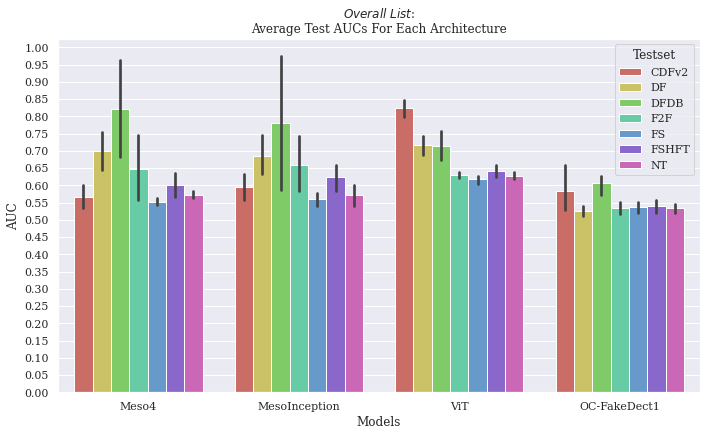

Bar_All


In [165]:
plt.figure(figsize=(11.5, 6.5))
# plot_order = df.groupby('Cause Name')['Deaths'].sum().sort_values(ascending=False).index.values
ax = sns.barplot(
    x="Model_Name",
    y="AUC",
    hue="Testset",
    data=df,
    hue_order=['CDFv2', 'DF', 'DFDB', 'F2F', 'FS', 'FSHFT', 'NT'],
    order=['Meso4', 'MesoInception', 'ViT', 'OC-FakeDect1'],
    palette="hls",
)
title = f"$Overall$ $List$:\nAverage Test AUCs For Each Architecture"
fname = "Bar_All"
ax.set_title(title)
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.set_xlabel("Models")
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()
print(fname)


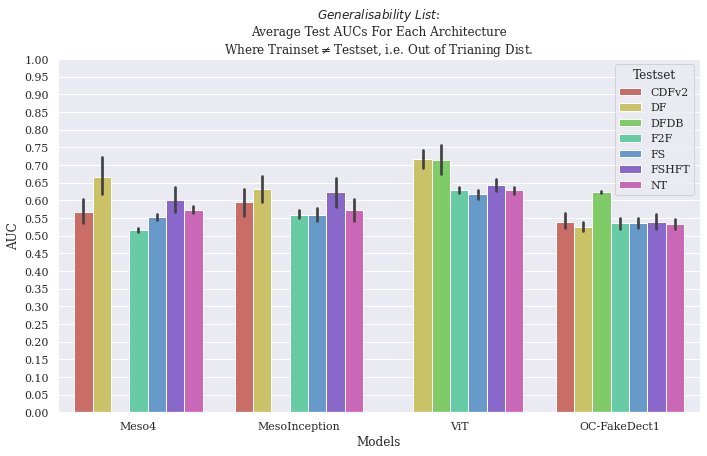

Bar_Generalisability


In [164]:
plt.figure(figsize=(11.5, 6.5))
ax = sns.barplot(
    x="Model_Name",
    y="AUC",
    hue="Testset",
    data=best_gen_models,
    hue_order=['CDFv2', 'DF', 'DFDB', 'F2F', 'FS', 'FSHFT', 'NT'],
    order=['Meso4', 'MesoInception', 'ViT', 'OC-FakeDect1'],
    palette="hls",
)
title = f"$Generalisability$ $List$:\nAverage Test AUCs For Each Architecture\nWhere Trainset$\\neq$Testset, i.e. Out of Trianing Dist."
fname = "Bar_Generalisability"
ax.set_title(title)
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.set_xlabel("Models")
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()
print(fname)


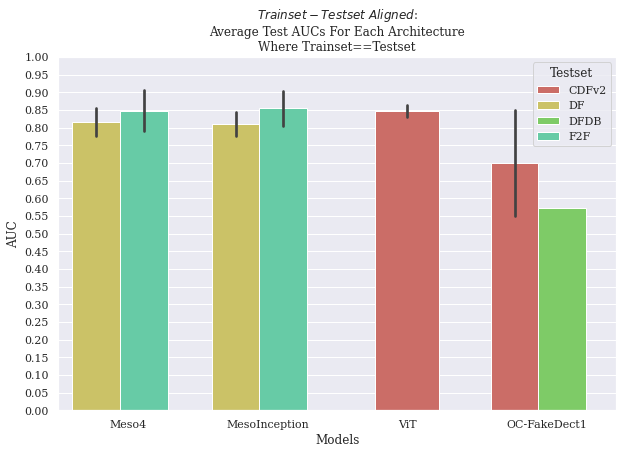

Bar_PreProcAligned


In [138]:
fig, ax = plt.subplots(figsize=(10, 6.5))
g = sns.barplot(
    x="Model_Name",
    y="AUC",
    hue="Testset",
    data=best_axis_aligned_models,
    hue_order=['CDFv2', 'DF', 'DFDB', 'F2F', None, None, None],
    order=['Meso4', 'MesoInception', 'ViT', 'OC-FakeDect1'],
    palette="hls",
)

for idx, patch in enumerate(ax.patches):
    if idx == 2: # vit
        current_width = patch.get_width()
        current_pos = patch.get_x()
        current_height = patch.get_height()
        patch.set_width(current_width*4)
        patch.set_x(current_pos + (1.5*current_width))
        ax.axes.lines[idx].set_xdata(current_pos + (1.5*current_width) + current_width*4*0.5)    
    if idx == 3: # oc red
        current_width = patch.get_width()
        current_pos = patch.get_x()
        current_height = patch.get_height()
        patch.set_width(current_width*3)
        patch.set_x(current_pos)
        ax.axes.lines[idx].set_xdata(current_pos + current_width*3*0.5)  
    if idx == 11: # oc green
        current_width = patch.get_width()
        current_pos = patch.get_x()
        current_height = patch.get_height()
        patch.set_width(current_width*3)
        patch.set_x(current_pos + (1*current_width))
    if idx == 4 or idx == 5: # yellow12
        current_width = patch.get_width()
        current_pos = patch.get_x()
        current_height = patch.get_height()
        patch.set_width(current_width*4)
        patch.set_x(current_pos - (1*current_width))
    if idx == 12 or idx == 13: # turq12
        current_width = patch.get_width()
        current_pos = patch.get_x()
        current_height = patch.get_height()
        patch.set_width(current_width*3)
        patch.set_x(current_pos)
        ax.axes.lines[idx].set_xdata(current_pos + current_width*3*0.5)  

title = f"$Trainset-Testset$ $Aligned$:\nAverage Test AUCs For Each Architecture\nWhere Trainset==Testset"
fname = "Bar_PreProcAligned"
g.set_title(title)
g.set_yticks(np.arange(0, 1.05, 0.05))
g.set_xlabel("Models")
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()
print(fname)


### Pre-Processing

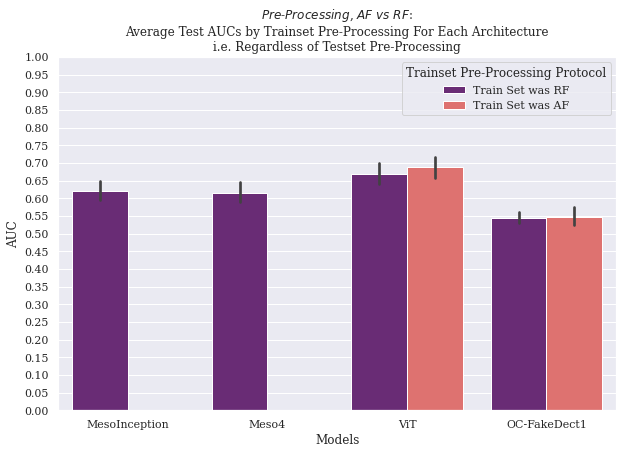

Bar_AUCs_byTestPreProc


In [139]:
plt.figure(figsize=(10, 6.5))
ax = sns.barplot(
    x="Model_Name", 
    y="AUC", 
    hue="is_AVG_Trainset", 
    data=df, 
    palette="magma")
title = f"$Pre$-$Processing$, $AF$ $vs$ $RF$:\nAverage Test AUCs by Trainset Pre-Processing For Each Architecture\ni.e. Regardless of Testset Pre-Processing"
fname = "Bar_AUCs_byTestPreProc"
ax.set_title(title)
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.set_xlabel("Models")
ax.legend(
    handles=ax.legend_.legendHandles,
    labels=["Train Set was RF", "Train Set was AF"],
    loc="upper right",
    title=f"Trainset Pre-Processing Protocol",
)
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()
print(fname)


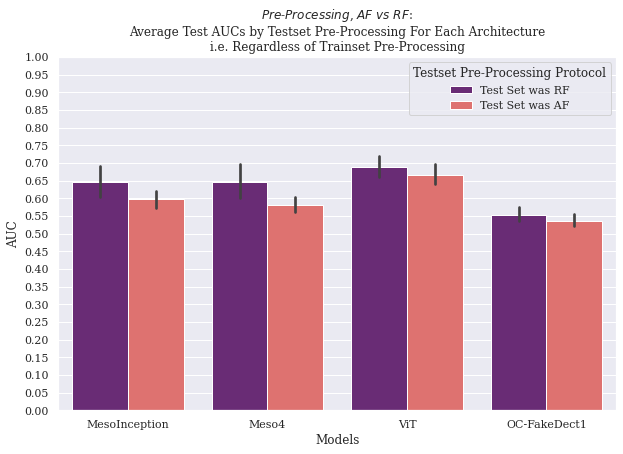

Bar_AUCs_byTestPreProc


In [140]:
plt.figure(figsize=(10, 6.5))
ax = sns.barplot(
    x="Model_Name", 
    y="AUC", 
    hue="is_AVG_Testset", 
    data=df, 
    palette="magma")
title = f"$Pre$-$Processing$, $AF$ $vs$ $RF$:\nAverage Test AUCs by Testset Pre-Processing For Each Architecture\ni.e. Regardless of Trainset Pre-Processing"
fname = "Bar_AUCs_byTestPreProc"
ax.set_title(title)
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.set_xlabel("Models")
ax.legend(
    handles=ax.legend_.legendHandles,
    labels=["Test Set was RF", "Test Set was AF"],
    loc="upper right",
    title=f"Testset Pre-Processing Protocol",
)
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()
print(fname)


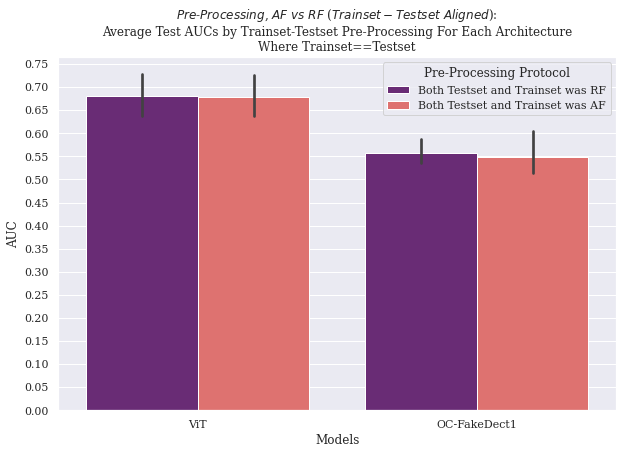

Bar_PreProcAlligned


In [141]:
s1 = df.loc[(df["is_AVG_Testset"] == 1) & (df["is_AVG_Trainset"] == 1)].copy()
s1["is_TrainTest_PreProc_Alligned"] = 1

s2 = df.loc[
    (df["is_AVG_Testset"] == 0)
    & (df["is_AVG_Trainset"] == 0)
    & (df["Model_Name"] != "Meso4")
    & (df["Model_Name"] != "MesoInception")].copy()
s2["is_TrainTest_PreProc_Alligned"] = 0

# s3 = df.loc[
#     (df["is_AVG_Testset"] == 1) 
#     & (df["is_AVG_Trainset"] == 0)
#     & (df["Model_Name"] != "Meso4")
#     & (df["Model_Name"] != "MesoInception")].copy()

# s3["is_TrainTest_PreProc_Alligned"] = 0
# s4 = df.loc[
#     (df["is_AVG_Testset"] == 0)
#     & (df["is_AVG_Trainset"] == 1)
#     & (df["Model_Name"] != "Meso4")
#     & (df["Model_Name"] != "MesoInception")].copy()
# s4["is_TrainTest_PreProc_Alligned"] = 0

plt.figure(figsize=(10, 6.5))
ax = sns.barplot(
    x="Model_Name",
    y="AUC",
    hue="is_TrainTest_PreProc_Alligned",
    data=pd.concat([s1, s2]),#, s3, s4]),
    palette="magma",
)

title = f"$Pre$-$Processing$, $AF$ $vs$ $RF$ ($Trainset-Testset$ $Aligned$):\nAverage Test AUCs by Trainset-Testset Pre-Processing For Each Architecture\nWhere Trainset==Testset"
ax.set_title(title)
ax.set_yticks(np.arange(0, 0.8, 0.05))
ax.set_xlabel("Models")
ax.legend(
    handles=ax.legend_.legendHandles,
    labels=["Both Testset and Trainset was RF", "Both Testset and Trainset was AF"],
    loc="upper right",
    title=f"Pre-Processing Protocol",
)
fname = "Bar_PreProcAlligned"
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()
print(fname)


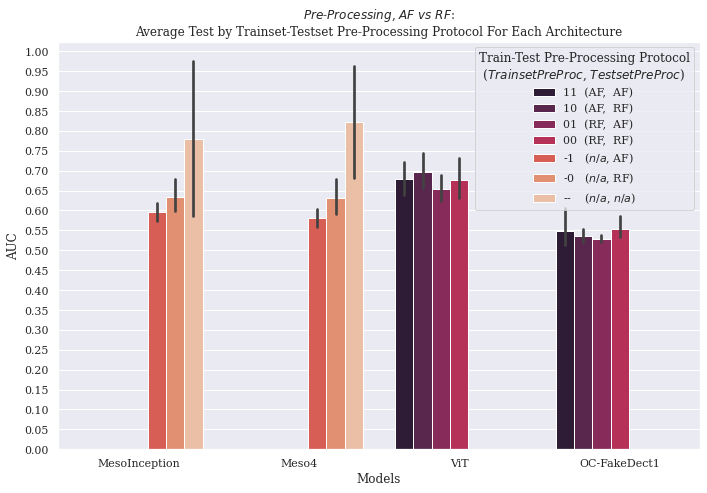

Bar_by_(TestTrain)PreProc


In [142]:
plt.figure(figsize=(11.5, 7.5))
dfx = df.copy()
dfx.loc[dfx["Testset"] == "DFDB", "is_RAE"] = "-"
dfx.loc[dfx["Testset"] == "DFDB", "is_AVG_Testset"] = "-"
dfx.loc[(dfx["Trainset"] == "F2F") & (dfx["Model_Name"] == "Meso4"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "F2F") & (dfx["Model_Name"] == "MesoInception"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "DF") & (dfx["Model_Name"] == "Meso4"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "DF") & (dfx["Model_Name"] == "MesoInception"), "is_AVG_Trainset"] = "-"

dfx["is_AVG_Trainset + is_AVG_Testset"] = dfx["is_AVG_Trainset"].astype(str) + dfx["is_AVG_Testset"].astype(str)
ax = sns.barplot(
    x="Model_Name",
    y="AUC",
    hue="is_AVG_Trainset + is_AVG_Testset",
    data=dfx,
    hue_order=["--", "-0", "-1", "00", "01", "10", "11"][::-1],
    palette="rocket"
)
ax.legend(
    handles=ax.legend_.legendHandles,
    labels=["--    ($n/a$, $n/a$)", "-0   ($n/a$, RF)", "-1   ($n/a$, AF)", "00  (RF,  RF)", "01  (RF,  AF)", "10  (AF,  RF)", "11  (AF,  AF)"][::-1],
    # loc="lower left",
    loc="best",
    title=f"Train-Test Pre-Processing Protocol\n{' '*1}($Trainset PreProc$, $Testset PreProc$)",
)
title = f"$Pre$-$Processing$, $AF$ $vs$ $RF$:\nAverage Test by Trainset-Testset Pre-Processing Protocol For Each Architecture"
fname = "Bar_by_(TestTrain)PreProc"
ax.set_title(title)
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.set_xlabel("Models")
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()
print(fname)


### Evaluation Method

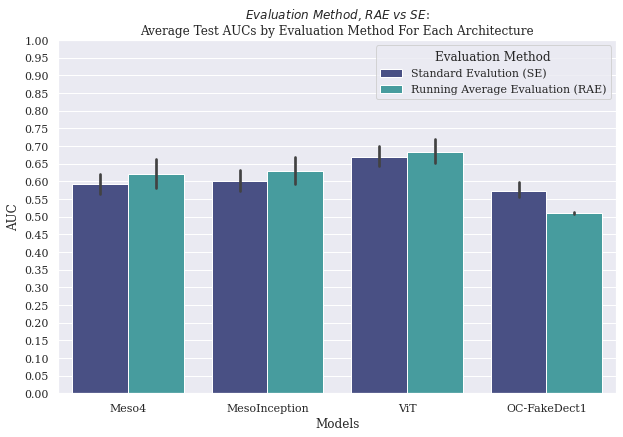

Bar_by_EvalMeth


In [143]:
plt.figure(figsize=(10, 6.5))
dfx = df.copy()
# IGNORE DFDB 
# Since it skews: we can't do RAE on it
# (but we can do SE, so it's not fair?) 
# So remove rows w/ "DFDB" (i.e. this graph only considers the datapoints which are applicable)
dfx.loc[dfx["Testset"] == "DFDB", "is_RAE"] = "-"
dfx = dfx[~(dfx["is_RAE"] == "-")]

ax = sns.barplot(
    x="Model_Name",
    y="AUC",
    hue="is_RAE",
    data=dfx,
    palette="mako"
)
ax.legend(
    handles=ax.legend_.legendHandles, 
    labels=['Standard Evalution (SE)', 
            'Running Average Evaluation (RAE)'],
    title="Evaluation Method"
    )
title = f"$Evaluation$ $Method$, $RAE$ $vs$ $SE$:\nAverage Test AUCs by Evaluation Method For Each Architecture"
fname = "Bar_by_EvalMeth"
ax.set_title(title)
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.set_xlabel("Models")
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()
print(fname)


### Pre-Processing vs Evaluation Method

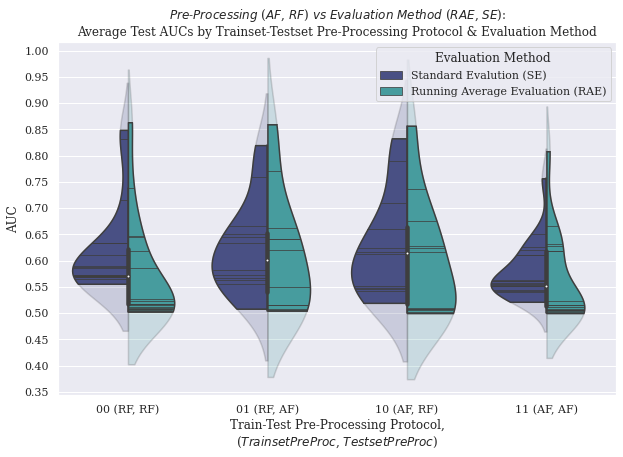

Violin_by_EvalMeth_N_(TrainTest)PreProc


In [144]:
plt.figure(figsize=(10, 6.5))
dfx = df.copy()
# IGNORE DFDB 
# Since it skews: it's not actually RF and we can't do RAE on it
# (but we can do SE, so it's not fair?) 
# So remove rows w/ "DFDB" (i.e. this graph only considers the datapoints which are applicable)
dfx.loc[dfx["Testset"] == "DFDB", "is_RAE"] = "-"
dfx.loc[dfx["Testset"] == "DFDB", "is_AVG_Testset"] = "-"
dfx.loc[(dfx["Trainset"] == "F2F") & (dfx["Model_Name"] == "Meso4"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "F2F") & (dfx["Model_Name"] == "MesoInception"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "DF") & (dfx["Model_Name"] == "Meso4"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "DF") & (dfx["Model_Name"] == "MesoInception"), "is_AVG_Trainset"] = "-"
dfx = dfx[~(dfx["is_AVG_Trainset"] == "-")]
dfx = dfx[~(dfx["is_AVG_Testset"] == "-")]
dfx = dfx[~(dfx["is_RAE"] == "-")]
dfx["is_AVG_Trainset + is_AVG_Testset"] = dfx["is_AVG_Trainset"].astype(str) + dfx["is_AVG_Testset"].astype(str)


bx = sns.violinplot(
    x="is_AVG_Trainset + is_AVG_Testset",
    y="AUC",
    hue="is_RAE",
    data=dfx,
    inner="stick",
    split=True, 
    cut=2-.2,  
    palette="mako",
    aspect=1,
    height=100,
    alpha=[0.2, 0.2],
)
plt.setp(bx.collections, alpha=.2)
ax = sns.violinplot(
    x="is_AVG_Trainset + is_AVG_Testset",
    y="AUC",
    hue="is_RAE",
    data=dfx,
    split=True, 
    cut=0,  
    palette="mako",
    aspect=1,
    height=100,
    dodge=True,
)
ax.legend(
    handles=ax.legend_.legendHandles, 
    labels=['Standard Evalution (SE)', 
    'Running Average Evaluation (RAE)'],
    title="Evaluation Method"
    )
    
title = f"$Pre$-$Processing$ ($AF$, $RF$) $vs$ $Evaluation$ $Method$ ($RAE$, $SE$):\nAverage Test AUCs by Trainset-Testset Pre-Processing Protocol & Evaluation Method"
fname = "Violin_by_EvalMeth_N_(TrainTest)PreProc"
ax.set_title(title)
ax.set_xticklabels(["00 (RF, RF)", "01 (RF, AF)", "10 (AF, RF)", "11 (AF, AF)"],)
ax.set_yticks(np.arange(0.35, 1.025, 0.05))
ax.set_xlabel(f"Train-Test Pre-Processing Protocol,\n($Trainset PreProc$, $Testset PreProc$)")
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()
print(fname)


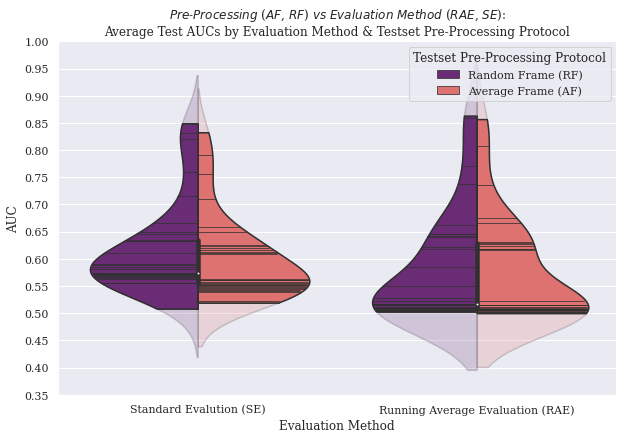

Violin_by_EvalMeth_N_PreProc


In [145]:
dfx = df.copy()
# IGNORE DFDB 
# Since it skews: it's not actually RF and we can't do RAE on it
# (but we can do SE, so it's not fair?) 
# So remove rows w/ "DFDB" (i.e. this graph only considers the datapoints which are applicable)
dfx.loc[dfx["Testset"] == "DFDB", "is_RAE"] = "-"
dfx.loc[dfx["Testset"] == "DFDB", "is_AVG_Testset"] = "-"
dfx.loc[(dfx["Trainset"] == "F2F") & (dfx["Model_Name"] == "Meso4"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "F2F") & (dfx["Model_Name"] == "MesoInception"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "DF") & (dfx["Model_Name"] == "Meso4"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "DF") & (dfx["Model_Name"] == "MesoInception"), "is_AVG_Trainset"] = "-"
dfx = dfx[~(dfx["is_AVG_Trainset"] == "-")]
dfx = dfx[~(dfx["is_AVG_Testset"] == "-")]
dfx = dfx[~(dfx["is_RAE"] == "-")]

plt.figure(figsize=(10, 6.5))

bx = sns.violinplot(
    x="is_RAE",
    y="AUC",
    hue="is_AVG_Testset",
    data=dfx,
    inner="stick",
    split=True, 
    # cut=2-.2,  
    palette="magma",
    aspect=1,
    height=100,
    alpha=[0.2, 0.2],
)
plt.setp(bx.collections, alpha=.2)
ax = sns.violinplot(
    x="is_RAE", 
    y='AUC', 
    hue="is_AVG_Testset", 
    data=dfx, 
    split=True, 
    cut=0,  
    palette="magma",
    aspect=1,
    height=100,
    )
ax.legend(
    handles=ax.legend_.legendHandles,
    labels=["Random Frame (RF)", "Average Frame (AF)"],
    loc="best",
    title="Testset Pre-Processing Protocol",
)
title = f"$Pre$-$Processing$ ($AF$, $RF$) $vs$ $Evaluation$ $Method$ ($RAE$, $SE$):\nAverage Test AUCs by Evaluation Method & Testset Pre-Processing Protocol"
fname = "Violin_by_EvalMeth_N_PreProc"
ax.set_title(title);
ax.set_xticklabels(['Standard Evalution (SE)', 
                    'Running Average Evaluation (RAE)'])
ax.set_xlabel("Evaluation Method")
ax.set_ylabel("AUC")
ax.set_yticks(np.arange(0.35, 1.025, 0.05))
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight"
    )
plt.show()
print(fname)

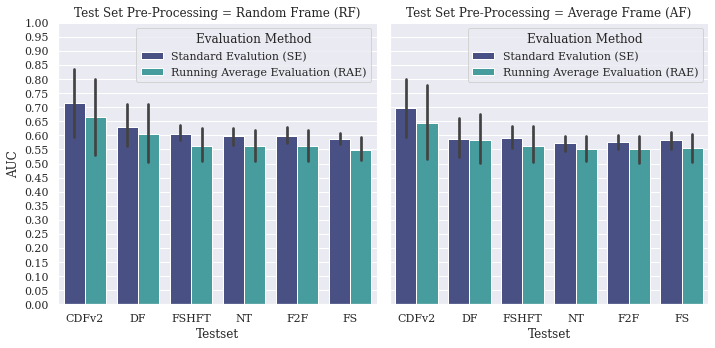

LBar_by_EvalMeth_N_TestPreProc


In [146]:
dfx = df.copy()
# IGNORE DFDB 
# Since it skews: it's not actually RF and we can't do RAE on it
# (but we can do SE, so it's not fair?) 
# So remove rows w/ "DFDB" (i.e. this graph only considers the datapoints which are applicable)
dfx.loc[dfx["Testset"] == "DFDB", "is_RAE"] = "-"
dfx.loc[dfx["Testset"] == "DFDB", "is_AVG_Testset"] = "-"
dfx.loc[(dfx["Trainset"] == "F2F") & (dfx["Model_Name"] == "Meso4"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "F2F") & (dfx["Model_Name"] == "MesoInception"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "DF") & (dfx["Model_Name"] == "Meso4"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "DF") & (dfx["Model_Name"] == "MesoInception"), "is_AVG_Trainset"] = "-"
dfx = dfx[~(dfx["is_AVG_Trainset"] == "-")]
dfx = dfx[~(dfx["is_AVG_Testset"] == "-")]
dfx = dfx[~(dfx["is_RAE"] == "-")]

ax = sns.catplot(
    x="Testset",
    y="AUC",
    hue="is_RAE",
    hue_order=[0, 1],
    col="is_AVG_Testset",
    data=dfx,
    kind="bar",
    height=5,
    aspect=1,
    palette="mako",
    legend_out=False,
)
# ax.fig.suptitle(
#     f"Pre-Processing vs Evaluation Method:\nFurther In-Depth (Split by Test Set) AUC of All Models by Test Set Pre-Processing Protocall & Evaluation Method",
#     y=1.1,
#     fontdict={"weight": "bold"},
# )
ax.axes[0][0].set_title(f"Test Set Pre-Processing = Random Frame (RF)")
ax.axes[0][1].set_title(f"Test Set Pre-Processing = Average Frame (AF)")
ax, bx = ax.axes[0][0], ax.axes[0][1]
bx.legend()
bx.legend(
    handles=bx.legend_.legendHandles,
    labels=["Standard Evalution (SE)", "Running Average Evaluation (RAE)"],
    loc="best",
    title="Evaluation Method",
)
ax.legend(
    handles=bx.legend_.legendHandles,
    labels=["Standard Evalution (SE)", "Running Average Evaluation (RAE)"],
    loc="best",
    title="Evaluation Method",
)
ax.set_yticks(np.arange(0, 1.05, 0.05))
fname = "LBar_by_EvalMeth_N_TestPreProc"
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight"
)
plt.show()
print(fname)


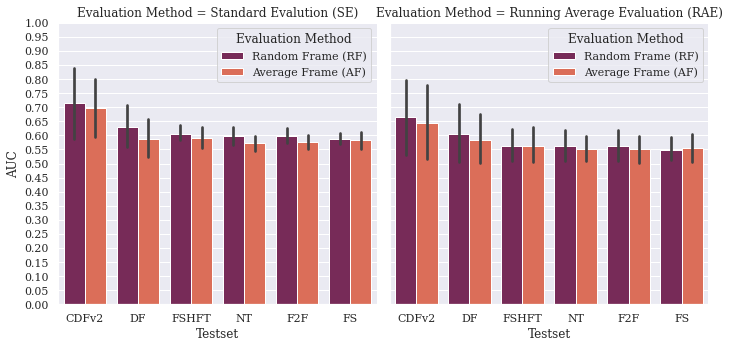

RBar_by_EvalMeth_N_TestPreProc


In [147]:
ax = sns.catplot(
    x="Testset",
    y="AUC",
    col="is_RAE",
    hue="is_AVG_Testset",
    data=dfx,
    kind="bar",
    hue_order=[0, 1],
    height=5,
    aspect=1,
    palette="rocket",
    legend_out=False,
)
# ax.fig.suptitle(
#     f"Pre-Processing vs Evaluation Method:\nFurther In-Depth (Split by Test Set) AUC of All Models by Test Set Pre-Processing Protocall & Evaluation Method",
#     y=1.1,
#     fontdict={"weight": "bold"},
# )
ax.axes[0][0].set_title(f"Evaluation Method = Standard Evalution (SE)")
ax.axes[0][1].set_title(f"Evaluation Method = Running Average Evaluation (RAE)")
ax, bx = ax.axes[0][0], ax.axes[0][1]
bx.legend()
bx.legend(
    handles=bx.legend_.legendHandles,
    labels=["Random Frame (RF)", "Average Frame (AF)"],
    loc="best",
    title="Evaluation Method",
)
ax.legend(
    handles=bx.legend_.legendHandles,
    labels=["Random Frame (RF)", "Average Frame (AF)"],
    loc="best",
    title="Evaluation Method",
)
ax.set_yticks(np.arange(0.0, 1.05, 0.05))
fname = "RBar_by_EvalMeth_N_TestPreProc"
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight"
)
plt.show()
print(fname)


<br><br>
___
## T-Tests

For all t-tests we use generalisable models (`best_gen_models`) we're only considering models where trainset $\neq$ testset. This we can eliminate the correlation of testing on the set you trained on, and thus we can use the t-test!

### Evaluation Method (RAE vs SE)

In [148]:
print("RAE VARIED")
dfx = best_gen_models.copy()
dfx["id"] = df["Model_Name"].astype(str) + df["Trainset"].astype(str) + df["Testset"].astype(str)
# including an id so that we can only consider paired models
# e.g. (Meso4, etc1) is comapred to (Meso4, etc2)
# where etc1 == etc2
A = "(RAE Models)"
a = dfx.loc[(dfx["is_RAE"] == 1)]
a = a.sort_values(by="id")

B = "(SE Models)"
b = dfx.loc[(dfx["is_RAE"] == 0)]
b =  b.loc[dfx["id"].isin([_ for _ in a["id"]])]
b = b.sort_values(by="id")

# Tests if alternative is TRUE
alternative="less" 
_, p_value = ttest_rel(
    a["AUC"], 
    b["AUC"], 
    alternative=alternative
    )
alternative_sym = alternative.replace("two-sided", "!=").replace("less", "<<").replace("greater", ">>")
print(f"p-value {p_value:.4f} < 0.05 ({p_value < 0.05}): \
      "+(f"\n{A} {alternative_sym} {B}"\
      if p_value < 0.05\
      else\
      f"\n{A} == {B}\nREJECT alternative={alternative}; Strong Evidence That Dists Are Equal"))


RAE VARIED
p-value 0.0947 < 0.05 (False):       
(RAE Models) == (SE Models)
REJECT alternative=less; Strong Evidence That Dists Are Equal


In [149]:
print("RAE VARIED")
dfx = best_gen_models.copy()
dfx["id"] = df["Model_Name"].astype(str) + df["Trainset"].astype(str) + df["Testset"].astype(str)
dfx = dfx.loc[~(dfx["Model_Name"]=="OC-FakeDect1")]
# including an id so that we can only consider paired models
# e.g. (Meso4, etc1) is comapred to (Meso4, etc2)
# where etc1 == etc2
A = "(RAE Models Minus OCFakeDect1s)"
a = dfx.loc[(dfx["is_RAE"] == 1)]
a = a.sort_values(by="id")

B = "(SE Models Minus OCFakeDect1s)"
b = dfx.loc[(dfx["is_RAE"] == 0)]
b =  b.loc[dfx["id"].isin([_ for _ in a["id"]])]
b = b.sort_values(by="id")

# Tests if alternative is TRUE
# Testing if the mean of the distribution underlying the first sample is
# greater than the mean of the distribution underlying the second sample.
alternative="greater" 
_, p_value = ttest_rel(
    a["AUC"], 
    b["AUC"], 
    alternative=alternative
    )
alternative_sym = alternative.replace("two-sided", "!=").replace("less", "<<").replace("greater", ">>")
print(f"p-value {p_value:.4f} < 0.05 ({p_value < 0.05}): \
      "+(f"\n{A} {alternative_sym} {B}"\
      if p_value < 0.05\
      else\
      f"\n{A} == {B}\nREJECT alternative={alternative}; Strong Evidence That Dists Are Equal"))

RAE VARIED
p-value 0.0009 < 0.05 (True):       
(RAE Models Minus OCFakeDect1s) >> (SE Models Minus OCFakeDect1s)


### Pre-Processing Protocol, T-Test Tables

In [150]:
# J = []
# dfx = best_gen_models.copy()
# dfx["id"] = df["Model_Name"].astype(str) + df["Trainset"].astype(str) + df["Testset"].astype(str)
# # print("Trainset PreProc, TestsetPreProc")
# print("SE=\{0,1\}, RAE=\{0,1\}")
# for i, j in [(0,0), (0,1), (1,0), (1,1)]:
        
#     A = f"({i})".replace("0", "SE").replace("1", "RAE")
#     a = dfx.loc[(dfx["is_RAE"] == 1)]
#     a = a.sort_values(by="id")

#     B = f"({j})".replace("0", "SE").replace("1", "RAE")
#     b = dfx.loc[(dfx["is_RAE"] == 1)]
#     b = b.sort_values(by="id")

#     a = a.loc[a["id"].isin([_ for _ in b["id"]])]
#     b = b.loc[b["id"].isin([_ for _ in a["id"]])]

#     # alternative="greater"
#     for alternative in ("less", "greater", "two-sided"):
#     # for alternative in ["greater"]:
#         _, p_value = ttest_rel(
#             a["AUC"], 
#             b["AUC"], 
#             alternative=alternative
#             )
#         alternative_sym = alternative.replace("two-sided", "!=").replace("less", "<<").replace("greater", ">>")

#         # if p_value < 0.05:
#         print(f"p-value {p_value:.4f} < 0.05 ({p_value < 0.05}): \
#             "+(f"\n{A} {alternative_sym} {B}"\
#             if p_value < 0.05\
#             else\
#             f"\n{A} == {B}\nREJECT alternative={alternative}; Strong Evidence That Dists Are Equal"), end="\n\n")
#         J += [(A, B, p_value, f"{A}{alternative_sym}{B}" if p_value<0.05 else f"{A}=={B}")]

In [151]:
L = []
dfx = best_gen_models.copy()
dfx["id"] = df["Model_Name"].astype(str) + df["Trainset"].astype(str) + df["Testset"].astype(str)
print("Trainset PreProc, TestsetPreProc")
print("RF=\{0,1\}, AF=\{0,1\}")
for i, j in [(0,0), (0,1), (1,0), (1,1)]:
    for k, q in [(0,0), (0,1), (1,0), (1,1)]:
        # i,j,k,q = list(map(str, (i,j,k,q)))
        
        A = f"({i}, {j})".replace("0", "RF").replace("1", "AF")
        a = dfx.loc[(dfx["is_AVG_Trainset"] == i) & (dfx["is_AVG_Testset"]== j)]
        a = a.sort_values(by="id")

        B = f"({k}, {q})".replace("0", "RF").replace("1", "AF")
        b = dfx.loc[(dfx["is_AVG_Trainset"] == k) & (dfx["is_AVG_Testset"]== q)]
        b = b.sort_values(by="id")

        a = a.loc[a["id"].isin([_ for _ in b["id"]])]
        b = b.loc[b["id"].isin([_ for _ in a["id"]])]

        # alternative="greater"
        for alternative in ("less", "greater", "two-sided"):
        # for alternative in ["greater"]:
            _, p_value = ttest_rel(
                a["AUC"], 
                b["AUC"], 
                alternative=alternative
                )
            alternative_sym = alternative.replace("two-sided", "!=").replace("less", "<<").replace("greater", ">>")

            # if p_value < 0.05:
            # print(f"p-value {p_value:.4f} < 0.05 ({p_value < 0.05}): \
            #     "+(f"\n{A} {alternative_sym} {B}"\
            #     if p_value < 0.05\
            #     else\
            #     f"\n{A} == {B}\nREJECT alternative={alternative}; Strong Evidence That Dists Are Equal"), end="\n\n")
            L += [(A, B, p_value, f"{A}{alternative_sym}{B}" if p_value<0.05 else "-", f"{A}=={B}" if p_value>=0.05 else "-")]
L

Trainset PreProc, TestsetPreProc
RF=\{0,1\}, AF=\{0,1\}


[('(RF, RF)', '(RF, RF)', nan, '-', '-'),
 ('(RF, RF)', '(RF, RF)', nan, '-', '-'),
 ('(RF, RF)', '(RF, RF)', nan, '-', '-'),
 ('(RF, RF)', '(RF, AF)', 0.9988024544951286, '-', '(RF, RF)==(RF, AF)'),
 ('(RF, RF)', '(RF, AF)', 0.0011975455048714447, '(RF, RF)>>(RF, AF)', '-'),
 ('(RF, RF)', '(RF, AF)', 0.0023950910097428895, '(RF, RF)!=(RF, AF)', '-'),
 ('(RF, RF)', '(AF, RF)', 0.23220133612053828, '-', '(RF, RF)==(AF, RF)'),
 ('(RF, RF)', '(AF, RF)', 0.7677986638794617, '-', '(RF, RF)==(AF, RF)'),
 ('(RF, RF)', '(AF, RF)', 0.46440267224107656, '-', '(RF, RF)==(AF, RF)'),
 ('(RF, RF)', '(AF, AF)', 0.7197694971322999, '-', '(RF, RF)==(AF, AF)'),
 ('(RF, RF)', '(AF, AF)', 0.28023050286770024, '-', '(RF, RF)==(AF, AF)'),
 ('(RF, RF)', '(AF, AF)', 0.5604610057354005, '-', '(RF, RF)==(AF, AF)'),
 ('(RF, AF)', '(RF, RF)', 0.0011975455048714447, '(RF, AF)<<(RF, RF)', '-'),
 ('(RF, AF)', '(RF, RF)', 0.9988024544951286, '-', '(RF, AF)==(RF, RF)'),
 ('(RF, AF)', '(RF, RF)', 0.0023950910097428895,

In [152]:
preProc_ttest_tab = pd.DataFrame(L, columns=["Group A (Train Pre-Proc', Test Pre-Proc')", "Group B (Train Pre-Proc', Test Pre-Proc')", "p-Value", "Accepted Alternate Hypothesis", "Accepted Null Hypothesis"])
preProc_ttest_tab = preProc_ttest_tab.sort_values(by="p-Value")
# preProc_ttest_tab = preProc_ttest_tab[(preProc_ttest_tab["p-Value"] < 0.05)] # significant
preProc_ttest_tab = preProc_ttest_tab.drop_duplicates(subset=[
    "Group A (Train Pre-Proc', Test Pre-Proc')", 
    "Group B (Train Pre-Proc', Test Pre-Proc')", 
    ]
)
preProc_ttest_tab = preProc_ttest_tab.dropna()
# preProc_ttest_tab = preProc_ttest_tab.drop_duplicates(subset=["p-Value"]) # drop converses a>b, b<=a (same thing and same p-val)
# preProc_ttest_tab = preProc_ttest_tab.drop_duplicates(subset=["Group A (Train Pre-Proc', Test Pre-Proc')"])
preProc_ttest_tab.index = range(1, len(preProc_ttest_tab)+1)
preProc_ttest_tab

,"Group A (Train Pre-Proc', Test Pre-Proc')","Group B (Train Pre-Proc', Test Pre-Proc')",p-Value,Accepted Alternate Hypothesis,Accepted Null Hypothesis
1,"(RF, RF)","(RF, AF)",0.001198,"(RF, RF)>>(RF, AF)",-
2,"(RF, AF)","(RF, RF)",0.001198,"(RF, AF)<<(RF, RF)",-
3,"(AF, AF)","(AF, RF)",0.005238,"(AF, AF)<<(AF, RF)",-
4,"(AF, RF)","(AF, AF)",0.005238,"(AF, RF)>>(AF, AF)",-
5,"(AF, RF)","(RF, AF)",0.007569,"(AF, RF)>>(RF, AF)",-
6,"(RF, AF)","(AF, RF)",0.007569,"(RF, AF)<<(AF, RF)",-
7,"(AF, AF)","(RF, AF)",0.098921,-,"(AF, AF)==(RF, AF)"
8,"(RF, AF)","(AF, AF)",0.098921,-,"(RF, AF)==(AF, AF)"
9,"(RF, RF)","(AF, RF)",0.232201,-,"(RF, RF)==(AF, RF)"
10,"(AF, RF)","(RF, RF)",0.232201,-,"(AF, RF)==(RF, RF)"


<br><br>
___
## AUC Plots

In [153]:
dfx = dfid.loc[(dfid["Trainset"] != dfid["Testset"])].copy()
dfx["Trainset + Testset"] = dfid["Trainset"].astype(str) + dfid["Testset"].astype(str)
dfx = dfx.loc[(dfx["Trainset"] != dfx["Testset"])]
dfx = dfx.loc[dfx["Trainset + Testset"] != "DFDFDB"] # Only Meso4 & MesoInception have trian-test as DFDFDB
dfx = dfx.loc[dfx["Trainset + Testset"] != "F2FDFDB"] # Only Meso4 & MesoInception have trian-test as F2FDFDB
dfx = dfx.drop(columns=["Trainset + Testset"])
dfid_best_gen_models = dfx

dfid_best_gen_models = dfid_best_gen_models.drop_duplicates(subset=["Model_Name"])
dfid_best_gen_models

,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,fname,is_RAE,is_AVG_Trainset,is_AVG_Testset
20,ViT,CDFv2,DF,0.769894,0.660518,0.511258,0.932866,ViT_AVG_raeonDFrnd,1,1,0
24,Meso4,F2F,DF,0.750952,0.339038,0.285714,0.416834,Meso4_F2F_raeonDFrnd,1,0,0
31,MesoInception,DF,FSHFT,0.692479,0.381877,0.320217,0.472946,MesoInception_DF_raeonFSHFTrnd,1,0,0
72,OC-FakeDect1,CDFv2,DFDB,0.627253,0.338380,0.290803,0.404569,OC-FakeDect1_RND_onDFDB,0,0,0


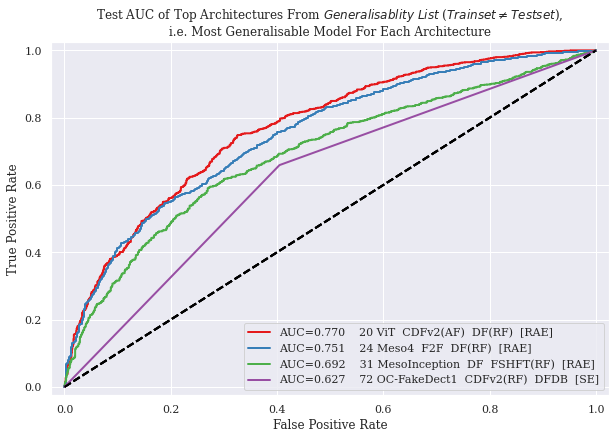

In [154]:
plt.figure(figsize=(10, 6.5))
sns.set_palette("Set1")
for model_fname in dfid_best_gen_models["fname"]:
    try:
        tpr, fpr, experiment_name = get_metric_from_file(f"{vit_results_dir}{model_fname}.txt", "tfpr")
    except FileNotFoundError:
        try: 
            tpr, fpr, experiment_name = get_metric_from_file(f"{baseline_results_dir}{model_fname}.txt", "tfpr")
        except FileNotFoundError:
            try: 
                tpr, fpr, experiment_name = get_metric_from_file(f"{oc_fakedect1_results_dir}{model_fname}.txt", "tfpr")
            except FileNotFoundError:
                print("Error?")
                break

    picked_model = dfid_best_gen_models.loc[dfid_best_gen_models["fname"] == model_fname]

    auroc = picked_model["AUC"]
    picked_model.index

    model_fname = model_fname.replace("AVG", "CDFv2(AF)").replace("RND", "CDFv2(RF)")
    model_fname = model_fname.replace("avg", "(AF)").replace("rnd", "(RF)")
    model_fname = model_fname.replace("_on", "")
    if "raeon" in model_fname or "running" in model_fname:
        model_fname = model_fname.replace("raeon", "")
        model_fname = model_fname.replace("running", "")
        model_fname = f"{model_fname}_[RAE]"
    else:
        model_fname = f"{model_fname}_[SE]"
    model_fname = model_fname.replace("_", "  ")
    model_fname = f"{picked_model.index[0]} {model_fname}"
    model_fname = f"AUC={float(auroc):.3f}    {model_fname}"
    model_fname = model_fname.replace(")D", ")  D")
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label=model_fname)#f'{model_fname}     [Area = %0.3f]' % auroc)
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    extra_xylim = 0.025
    plt.xlim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.ylim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title(f"AUROC of {experiment_name}")
    plt.title(f"Test AUC of Top Architectures From $Generalisablity$ $List$ ($Trainset \\neq Testset$),\ni.e. Most Generalisable Model For Each Architecture")#\nLabeling Scheme = $OverallOrder$ $Model$ $Trainset(TrainPreProc)$ $Testset(TestPreProc)$ $[EvalMeth]$")
    plt.legend(loc="lower right")
fname = f"AUC_Most_Gen"
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()

In [155]:
dfx = dfid.drop_duplicates("Model_Name").copy()
dfid_best_models = dfx
dfid_best_models = dfid_best_models.drop_duplicates(subset=["Model_Name"])
dfid_best_models

,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,fname,is_RAE,is_AVG_Trainset,is_AVG_Testset
1,MesoInception,DF,DFDB,0.975468,0.925492,0.952760,0.899742,MesoInception_DF_DFDB,0,0,0
2,Meso4,DF,DFDB,0.962168,0.904176,0.930221,0.879549,Meso4_DF_DFDB,0,0,0
5,ViT,CDFv2,CDFv2,0.863548,0.963113,0.930065,0.998596,ViT_RND_raeonRND,1,0,0
9,OC-FakeDect1,CDFv2,CDFv2,0.849139,0.427793,0.770485,0.296097,OC-FakeDect1_RND_onRND,0,0,0


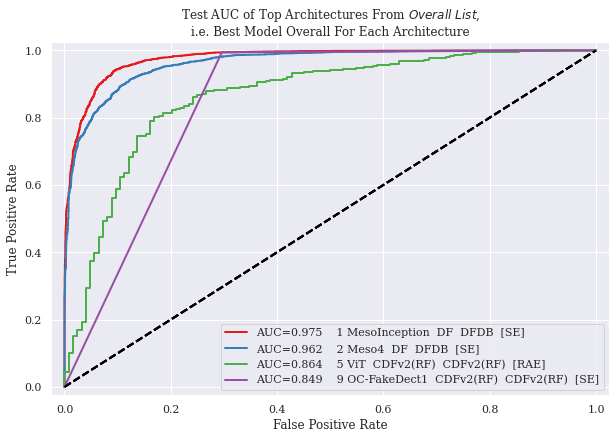

In [156]:
plt.figure(figsize=(10, 6.5))
sns.set_palette("Set1")
for model_fname in dfid_best_models["fname"]:
    try:
        tpr, fpr, experiment_name = get_metric_from_file(f"{vit_results_dir}{model_fname}.txt", "tfpr")
    except FileNotFoundError:
        try: 
            tpr, fpr, experiment_name = get_metric_from_file(f"{baseline_results_dir}{model_fname}.txt", "tfpr")
        except FileNotFoundError:
            try: 
                tpr, fpr, experiment_name = get_metric_from_file(f"{oc_fakedect1_results_dir}{model_fname}.txt", "tfpr")
            except FileNotFoundError:
                print("Error?")
                break

    picked_model = dfid_best_models.loc[dfid_best_models["fname"] == model_fname]

    auroc = picked_model["AUC"]
    picked_model.index

    model_fname = model_fname.replace("AVG", "CDFv2(AF)").replace("RND", "CDFv2(RF)")
    model_fname = model_fname.replace("avg", "(AF)").replace("rnd", "(RF)")
    model_fname = model_fname.replace("_on", "")
    if "raeon" in model_fname or "running" in model_fname:
        model_fname = model_fname.replace("raeon", "")
        model_fname = model_fname.replace("running", "")
        model_fname = f"{model_fname}_[RAE]"
    else:
        model_fname = f"{model_fname}_[SE]"
    model_fname = model_fname.replace("_", "  ")
    model_fname = f"{picked_model.index[0]} {model_fname}"
    model_fname = f"AUC={float(auroc):.3f}    {model_fname}"
    model_fname = model_fname.replace(")C", ")  C")
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label=model_fname)#f'{model_fname}     [Area = %0.3f]' % auroc)
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    extra_xylim = 0.025
    plt.xlim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.ylim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title(f"AUROC of {experiment_name}")
    plt.title(f"Test AUC of Top Architectures From $Overall$ $List$,\ni.e. Best Model Overall For Each Architecture")
    plt.legend(loc="lower right")
fname = f"AUC_Best_Overall"
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()

In [157]:
# from sklearn.metrics import classification_report, f1_score, roc_auc_score, precision_score

# plt.figure(figsize=(10, 6.5))
# sns.set_palette("Set1")
# for model_fname in dfid_best_models["fname"]:
#     try:
#         y_true, y_pred, experiment_name = get_metric_from_file(f"{vit_results_dir}{model_fname}.txt", "ytrueNypreds")
#     except FileNotFoundError:
#         try: 
#             y_true, y_pred, experiment_name = get_metric_from_file(f"{baseline_results_dir}{model_fname}.txt", "ytrueNypreds")
#         except FileNotFoundError:
#             try: 
#                 y_true, y_pred, experiment_name = get_metric_from_file(f"{oc_fakedect1_results_dir}{model_fname}.txt", "ytrueNypreds")
#             except FileNotFoundError:
#                 print("Error?")
#                 break

#     y_true, y_pred = np.array(y_true), np.array(y_pred)

#     print(experiment_name)
#     threshold_canditates = []
#     for t in np.linspace(0, 1, 100):
#         y_pred_rint = (y_pred <= t).astype(float)
#         # threshold_canditates += [(precision_score(y_true, y_pred_rint, average=None)[0], t)]
#         f1_c0, f1_c1 = f1_score(y_true, y_pred_rint, average=None)
#         threshold_canditates += [((6.6*f1_c0 + f1_c1), t)]
#     #     # threshold_canditates += [(roc_auc_score(y_true, y_pred_rint), t)]
#     threshold = max(threshold_canditates, key=lambda t: t[0])[1]
#     threshold = 0.5
#     print(threshold)

#     print(classification_report(y_true, (y_pred <= threshold).astype(float), labels=[0.0, 1.0]))
#     break

In [158]:
# dfx = dfid.loc[(df["Trainset"] == dfid["Testset"])].copy()
# dfx["id"] = dfx["Model_Name"].astype(str) + dfx["Trainset"].astype(str) + dfx["Testset"].astype(str) + dfx["is_RAE"].astype(str)
# dfx = dfx.drop_duplicates(subset=["id"])
# # dfx = dfx.drop(columns="id")
# dfx = dfx.loc[(dfx["Model_Name"] != "Meso4")].loc[(dfx["Model_Name"] != "MesoInception")]

In [159]:
# plt.figure(figsize=(10, 6.5))
# sns.set_palette("Set1")
# for model_fname in dfx["fname"]:
#     try:
#         tpr, fpr, experiment_name = get_metric_from_file(f"{vit_results_dir}{model_fname}.txt", "tfpr")
#     except FileNotFoundError:
#         try: 
#             tpr, fpr, experiment_name = get_metric_from_file(f"{baseline_results_dir}{model_fname}.txt", "tfpr")
#         except FileNotFoundError:
#             try: 
#                 tpr, fpr, experiment_name = get_metric_from_file(f"{oc_fakedect1_results_dir}{model_fname}.txt", "tfpr")
#             except FileNotFoundError:
#                 print("Error?")
#                 break

#     picked_model = dfx.loc[dfx["fname"] == model_fname]

#     auroc = picked_model["AUC"]
#     picked_model.index

#     model_fname = model_fname.replace("AVG", "CDFv2(AF)").replace("RND", "CDFv2(RF)")
#     model_fname = model_fname.replace("avg", "(AF)").replace("rnd", "(RF)")
#     model_fname = model_fname.replace("_on", "")
#     if "raeon" in model_fname or "running" in model_fname:
#         model_fname = model_fname.replace("raeon", "")
#         model_fname = model_fname.replace("running", "")
#         model_fname = f"{model_fname}_[RAE]"
#     else:
#         model_fname = f"{model_fname}_[SE]"
#     model_fname = model_fname.replace("_", "  ")
#     model_fname = f"{picked_model.index[0]} {model_fname}"
#     model_fname = f"AUC={float(auroc):.3f}    {model_fname}"
#     model_fname = model_fname.replace(")D", ")  D")
#     lw = 2
#     plt.plot(fpr, tpr, lw=lw, label=model_fname)#f'{model_fname}     [Area = %0.3f]' % auroc)
#     plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
#     extra_xylim = 0.025
#     plt.xlim([0.0 - extra_xylim, 1.0 + extra_xylim])
#     plt.ylim([0.0 - extra_xylim, 1.0 + extra_xylim])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     # plt.title(f"AUROC of {experiment_name}")
#     plt.title(f"Test AUC of Top Architectures From $Generalisablity$ $List$ ($Trainset \\neq Testset$),\ni.e. Most Generalisable Model For Each Architecture")#\nLabeling Scheme = $OverallOrder$ $Model$ $Trainset(TrainPreProc)$ $Testset(TestPreProc)$ $[EvalMeth]$")
#     plt.legend(loc="lower right")
# # fname = f"AUC_Most_Gen"
# # plt.savefig(
# #     f"./_PLOTS/{fname}.pdf", 
# #     bbox_inches="tight",
# #     )
# plt.show()

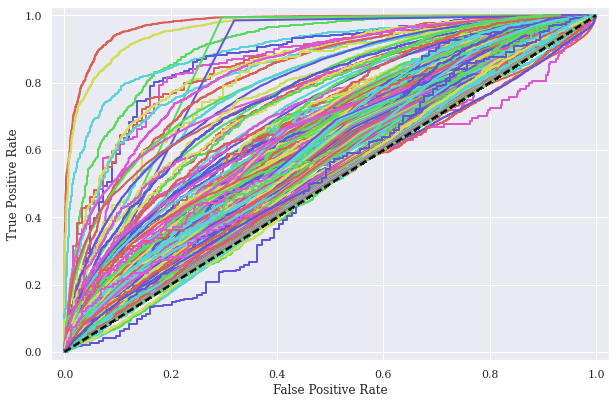

In [160]:
plt.figure(figsize=(10, 6.5))
sns.set_palette("hls")
dfidx = dfid.copy()
for model_fname in dfidx["fname"]:
    try:
        tpr, fpr, experiment_name = get_metric_from_file(f"{vit_results_dir}{model_fname}.txt", "tfpr")
    except FileNotFoundError:
        try: 
            tpr, fpr, experiment_name = get_metric_from_file(f"{baseline_results_dir}{model_fname}.txt", "tfpr")
        except FileNotFoundError:
            try: 
                tpr, fpr, experiment_name = get_metric_from_file(f"{oc_fakedect1_results_dir}{model_fname}.txt", "tfpr")
            except FileNotFoundError:
                print("Error?")
                break
    picked_model = dfidx.loc[dfidx["fname"] == model_fname]
    auroc = picked_model["AUC"]
    lw = 2
    plt.plot(fpr, tpr, lw=lw)
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    extra_xylim = 0.025
    plt.xlim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.ylim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plt.show()

<br><br>
___
# Loss Plots

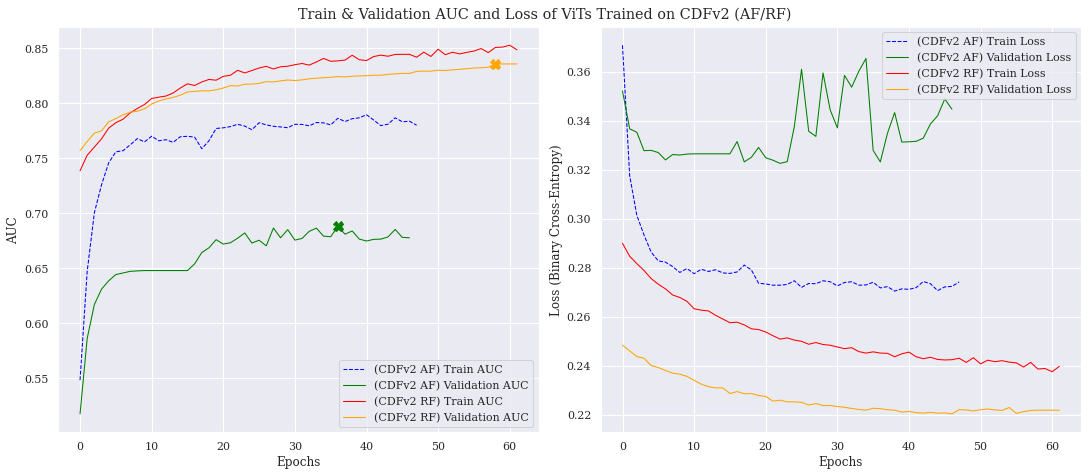

In [161]:
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(15, 6.5), constrained_layout=True)# plt.figure(1,2)#, figsize=(10, 6.5))
lw = 1.05

vit_avg_jout_fpath = r"_TRAINING\ViT\first_16_epochs_ViT_AVG_jupyteroutput"
lines = ""
with open(vit_avg_jout_fpath, "r") as f:
    lines += "".join(f.readlines())
losses = [float(l[-6:]) for l in re.findall("- ETA: 0s - loss: [\d].[\d]+", lines)]
val_losses = [float(l[-6:]) for l in re.findall("val_loss: [\d].[\d]+", lines)]
aucs = [float(a[-6:]) for a in re.findall("- ETA: 0s - loss: [\d].[\d]+ - auc: [\d].[\d]+", lines)]
val_aucs = [float(a[-6:]) for a in re.findall("val_auc: [\d].[\d]+", lines)]




ax2.plot(range(len(losses)), losses, "--", color="blue", lw=lw, label="(CDFv2 AF) Train Loss")
ax2.plot(range(len(val_losses)), val_losses, "-", color="green", lw=lw, label="(CDFv2 AF) Validation Loss")

ax1.plot(range(len(aucs)), aucs, "--", color="blue", lw=lw, label="(CDFv2 AF) Train AUC")
ax1.plot(range(len(val_aucs)), val_aucs, "-", color="green", lw=lw, label="(CDFv2 AF) Validation AUC")
ax1.plot(val_aucs.index(max(val_aucs)), max(val_aucs), marker="X", markersize=10, markeredgecolor="green", markerfacecolor="green")



vit_avg_jout_fpath = r"_TRAINING\ViT\first_47_epochs_ViT_RND_jupyteroutput"
lines = ""
with open(vit_avg_jout_fpath, "r") as f:
    lines += "".join(f.readlines())
losses = [float(l[-6:]) for l in re.findall("- ETA: 0s - loss: [\d].[\d]+", lines)]
aucs = [float(a[-6:]) for a in re.findall("- ETA: 0s - loss: [\d].[\d]+ - auc: [\d].[\d]+", lines)]
val_losses = [float(l[-6:]) for l in re.findall("val_loss: [\d].[\d]+", lines)]
val_losses = val_losses[:47] + [l-0.104 for l in val_losses[47:]]
val_aucs = [float(a[-6:]) for a in re.findall("val_auc: [\d].[\d]+", lines)]
val_aucs = val_aucs[:47] + [v+.125 for v in val_aucs[47:]]




ax2.plot(range(len(losses)), losses, "-", color="red", lw=lw, label="(CDFv2 RF) Train Loss")
ax2.plot(range(len(val_losses)), val_losses, "-", color="orange", lw=lw, label="(CDFv2 RF) Validation Loss")

ax1.plot(range(len(aucs)), aucs, "-", color="red", lw=lw, label="(CDFv2 RF) Train AUC")
ax1.plot(range(len(val_aucs)), val_aucs, "-", color="orange", lw=lw, label="(CDFv2 RF) Validation AUC")
ax1.plot(val_aucs.index(max(val_aucs)), max(val_aucs), marker="X", markersize=10, markeredgecolor="orange", markerfacecolor="orange")

ax1.legend()
ax2.legend()

ax1.set_ylabel("AUC")
ax2.set_ylabel("Loss (Binary Cross-Entropy)")
ax1.set_xlabel("Epochs")
ax2.set_xlabel("Epochs")
# ax1.set_title("Train & Validation AUC of ViTs")
# ax2.set_title("Train & Validation Loss of ViTs")
fig.suptitle('Train & Validation AUC and Loss of ViTs Trained on CDFv2 (AF/RF)')

fname = f"ViT_Training_Metrics"
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()